# Обучение с учителем: качество модели

## Описание проекта
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе.
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Описание данных
Файл market_file.csv - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
* id — номер покупателя в корпоративной базе данных.
* Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
* Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
* Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
* Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
* Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
* Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
* Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
* Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
* Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
* Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
* Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
* Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Файл market_money.csv - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
* Выручка — сумма выручки за период.

Файл market_time.csv - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксировано общее время.
* минут — значение времени, проведённого на сайте, в минутах.

Файл money.csv - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
* id — номер покупателя в корпоративной базе данных.
* Прибыль — значение прибыли.

In [1]:
!pip install phik shap category_encoders scikit-learn==1.3.0 -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from  sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from phik import phik_matrix
from matplotlib.gridspec import GridSpec
from phik.report import plot_correlation_matrix
from sklearn.pipeline import Pipeline
from category_encoders import BinaryEncoder

## Загрузка и изучение данных

In [3]:
try:
    df_market_file = pd.read_csv("market_file.csv")
    df_market_money = pd.read_csv("market_money.csv")
    df_market_time = pd.read_csv("market_time.csv")
    df_money = pd.read_csv("money.csv", sep=';', decimal=',')
except:
    df_market_file = pd.read_csv("/datasets/market_file.csv")
    df_market_money = pd.read_csv("/datasets/market_money.csv")
    df_market_time = pd.read_csv("/datasets/market_time.csv")
    df_money = pd.read_csv("/datasets/money.csv", sep=';', decimal=',')

In [4]:
print(df_market_file.info())
df_market_file.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


In [5]:
df_market_file.columns=['id','activity_type', 'service_type', 'spam_permission', 'activity_6_month_avg',
                        'activity_this_month_avg', 'days_from_registration', 'promotion_purchases_6_month_avg', 'best_category_6_month', 'amount_category_visit_this_month_avg', 'unpaid_products_3_month',
                        'site_errors_amount', 'amount_pages_visit_3_month_avg'
                        ]

In [6]:
print(df_market_money.info())
df_market_money.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


In [7]:
df_market_money.columns = ['id','revenue_period', 'revenue_amount']

In [8]:
print(df_market_time.info())
df_market_time.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


In [9]:
df_market_time.columns = ['id','activity_period', 'minutes']

In [10]:
print(df_money.info())
df_money.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
5,215353,3.95
6,215354,3.62
7,215355,5.26
8,215356,4.93
9,215357,4.66


In [11]:
df_money.columns = ['id', 'revenue_3_month_avg']

## Предобработка данных

Напишем функцию для подсчёта количества пропусков и явных дубликатов

In [12]:
def dup_pass_amount(df):
    print("Количество пропусков:\n", df.isna().sum(), sep='')
    print("\nКоличество дубликатов = ", df.duplicated(keep='first').sum())

Напишем функцию для поиска неявных дубликатов

In [13]:
def unique_values(df):
    for column in df.select_dtypes(include='object'):
        print(f'уникальные значения столбца {column} : {df[column].unique()}')

Попробуем найти неявные дубликаты

In [14]:
unique_values(df_market_file)

уникальные значения столбца activity_type : ['Снизилась' 'Прежний уровень']
уникальные значения столбца service_type : ['премиум' 'стандартт' 'стандарт']
уникальные значения столбца spam_permission : ['да' 'нет']
уникальные значения столбца best_category_6_month : ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


Заменим опечатку 'стандартт' в колонке service_type

In [15]:
df_market_file['service_type'].replace('стандартт', 'стандарт', inplace=True)

найдём количество пропусков и явных дубликатов

In [16]:
dup_pass_amount(df_market_file)
# удаляем дубликаты
df_market_file.drop_duplicates(inplace=True)

Количество пропусков:
id                                      0
activity_type                           0
service_type                            0
spam_permission                         0
activity_6_month_avg                    0
activity_this_month_avg                 0
days_from_registration                  0
promotion_purchases_6_month_avg         0
best_category_6_month                   0
amount_category_visit_this_month_avg    0
unpaid_products_3_month                 0
site_errors_amount                      0
amount_pages_visit_3_month_avg          0
dtype: int64

Количество дубликатов =  0


Проверим наличие дубликатов и пропусков в остальных датафреймах

In [17]:
unique_values(df_market_money)
dup_pass_amount(df_market_money)

уникальные значения столбца revenue_period : ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
Количество пропусков:
id                0
revenue_period    0
revenue_amount    0
dtype: int64

Количество дубликатов =  0


для дальнейшей работы разделим данные за каждый период по столбцам

In [18]:
df_market_money = df_market_money.pivot_table(values='revenue_amount', index='id', columns='revenue_period', aggfunc='sum')
df_market_money.columns = ['revenue_previous_month', 'revenue_previous_previous_month', 'revenue_current_month']

In [19]:
unique_values(df_market_time)
dup_pass_amount(df_market_time)

уникальные значения столбца activity_period : ['текущий_месяц' 'предыдцщий_месяц']
Количество пропусков:
id                 0
activity_period    0
minutes            0
dtype: int64

Количество дубликатов =  0


Удалим опечатку

In [20]:
df_market_time['activity_period'].replace('предыдцщий_месяц', 'предыдущий_месяц', inplace=True)

для дальнейшей работы разделим данные за каждый период по столбцам

In [21]:
df_market_time = df_market_time.pivot_table(values='minutes', index='id', columns='activity_period', aggfunc='sum')
df_market_time.columns=['minutes_previous_month', 'minutes_current_month']

In [22]:
unique_values(df_money)
dup_pass_amount(df_money)

Количество пропусков:
id                     0
revenue_3_month_avg    0
dtype: int64

Количество дубликатов =  0


Сделаем индексацию по id для остальных таблиц

In [23]:
df_market_file.set_index('id', inplace=True)
df_money.set_index('id', inplace=True)

### Промежуточный вывод по предобработке
При предобработке данных был найден и удалён неявный дубликат в столбце service_type датафрейма df_market_file, явных дубликатов и пропусков найдено не было. Разделили выручку и время проведённое на сайте по разным столбцам для каждого периода времени, а также добавили индексацию по id для всех столбцов. Также были удалены выбросы для последующего более удобного моделирования.

## Исследовательский анализ данных

Напишем функцию для раздельного анализа числовых и строковых столбцов

In [24]:
def columns_analysis(df):
    df_activity_down = df[df['activity_type'] == 'Снизилась']
    df_activity_unchanged = df[df['activity_type'] == 'Прежний уровень']
    for column in df.select_dtypes(include='object').columns:
        df[column].value_counts().plot.pie(autopct='%1.1f%%')
        plt.title(column)
        plt.ylabel('')
        plt.figure(figsize=(10, 10))
        plt.show(block=False)
    for column in df.select_dtypes(exclude='object').columns:
        gs = GridSpec(1, 2, width_ratios=[5, 2], wspace=1, figure=plt.figure(figsize=(6, 5)))
        ax1 = plt.subplot(gs[0])
        if df[column].nunique() < 8:
            df_activity_down[column].value_counts().sort_index().plot.bar(alpha=0.5, color='red', label='Activity Down')
            df_activity_unchanged[column].value_counts().sort_index().plot.bar(alpha=0.5, color='green', label='Activity Unchanged')
        else:
            df_activity_down[column].plot.kde(color='red', label='Activity Down')
            df_activity_unchanged[column].plot.kde(color='green', label='Activity Unchanged')
        plt.legend(loc='upper right', bbox_to_anchor=(1.8, 1))
        ax1.set_title(f"Распределение столбца {column}")  
        ax2 = plt.subplot(gs[1])
        text = df[column].describe().to_string()
        ax2.text(0, 0.5, text, ha='left', va='center', fontsize=12, linespacing=1.5)
        ax2.axis('off')
        plt.show()
    

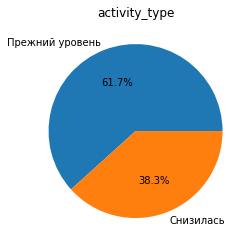

<Figure size 720x720 with 0 Axes>

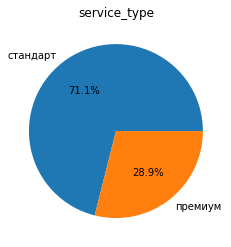

<Figure size 720x720 with 0 Axes>

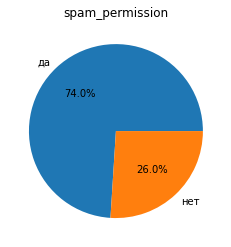

<Figure size 720x720 with 0 Axes>

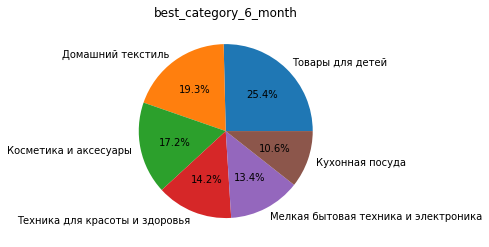

<Figure size 720x720 with 0 Axes>

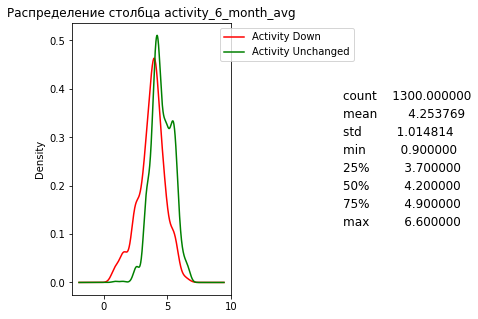

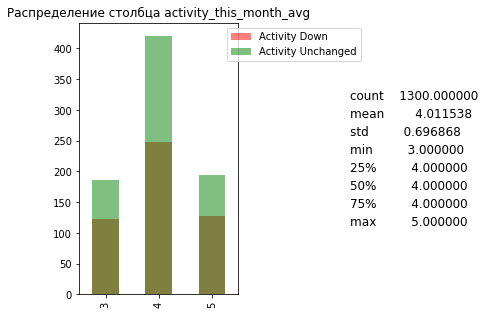

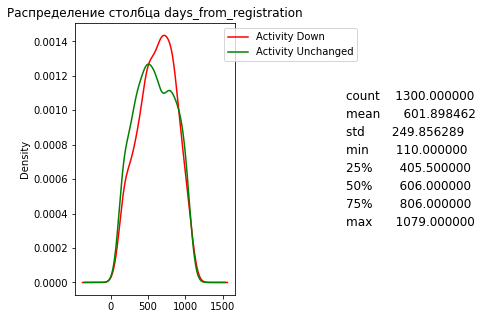

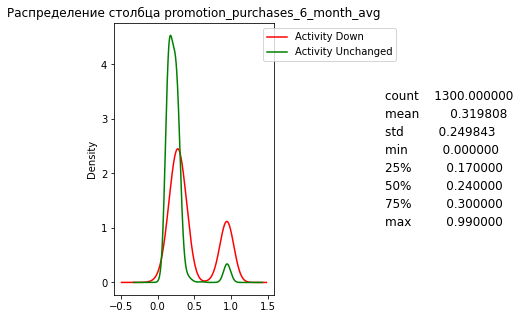

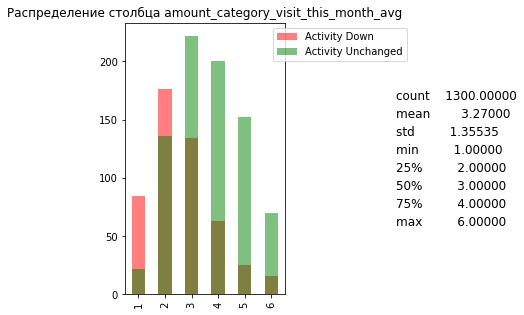

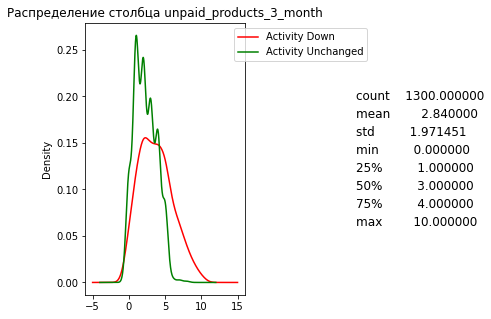

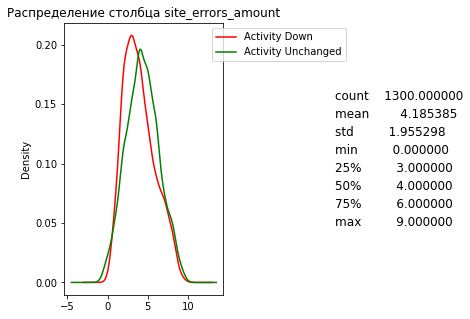

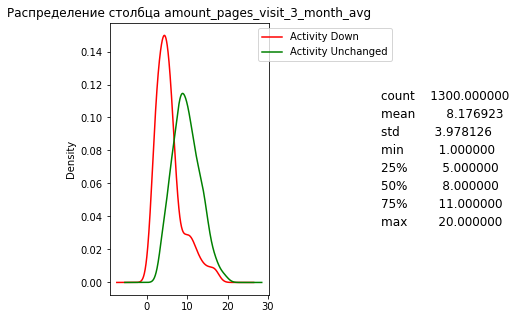

In [25]:
columns_analysis(df_market_file)

Так как для анализа нам нужны только данные по покупателям, которые были активны в последние 3 месяца, то отберём только их.

In [26]:
df_market_money_active = df_market_money[(df_market_money['revenue_current_month'] != 0) & (df_market_money['revenue_previous_month'] != 0) & (df_market_money['revenue_previous_previous_month'] != 0)]

In [27]:
df_market_money_active.describe()

,revenue_previous_month,revenue_previous_previous_month,revenue_current_month
count,1297.000000,1297.000000,1297.000000
mean,4948.339630,4836.367772,5316.449268
std,701.228571,333.438742,2942.469139
min,2890.000000,4098.000000,2758.700000
25%,4498.500000,4585.000000,4706.600000
50%,5005.500000,4812.000000,5180.300000
75%,5409.000000,5055.000000,5761.300000
max,6869.500000,5663.000000,106862.200000


Видим наличие очевидного выброса в стобце revenue_current_month, посмотрим один он или нет

<AxesSubplot:>

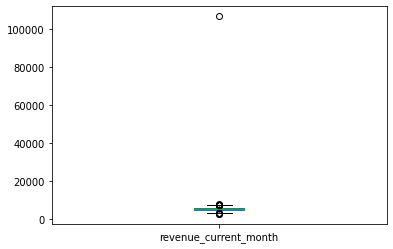

In [28]:
df_market_money_active['revenue_current_month'].plot(kind='box')

Выброс всего один, так что можем легко от него избавиться

<AxesSubplot:>

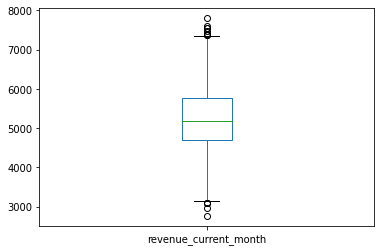

In [29]:
df_market_money_active = df_market_money_active[df_market_money_active['revenue_current_month'] < 20000]
df_market_money_active['revenue_current_month'].plot(kind='box')

теперь график выглядит нормально

### Промежуточный вывод по исследовательскому анализу
Большинство графиков численных столбцов показывают распределение похожее на нормальное, выделяется лишь столбец с  долей купленных акционных товаров - мы видим два типа покупателей, тех кто иногда пользуется акциями и тех кто закупается только на них. По категориальным признакам можно сказать, что нет категории товаров с сильно большей долей - все примерно равны, согласие на спам дают большинство клиентов, так же как и большинство клиентов не пользуется премиум подпиской. Также мы видим, что покупательская активность снизилась всего у 40% клиентов. Если же рассматривать графики с оглядкой на исследуемый признак, то можно заметить, что общее количество посещений сайта у людей соснизившейся активностью меньше, также видна их большая любовь к акциям, количество посещённых ими категорий в среднем меньше, они чаще не поатят за товары и в принципе за последние 3 месяца количество посещённых ими страниц меньше, чем у людей со стабильым интересом к сайту.

## Объединение таблиц

In [30]:
df_merged = pd.merge(df_market_file, df_market_money_active, left_index=True, right_index=True, how='inner')
df_merged = pd.merge(df_merged, df_market_time, left_index=True, right_index=True, how='inner')

## Корреляционный анализ

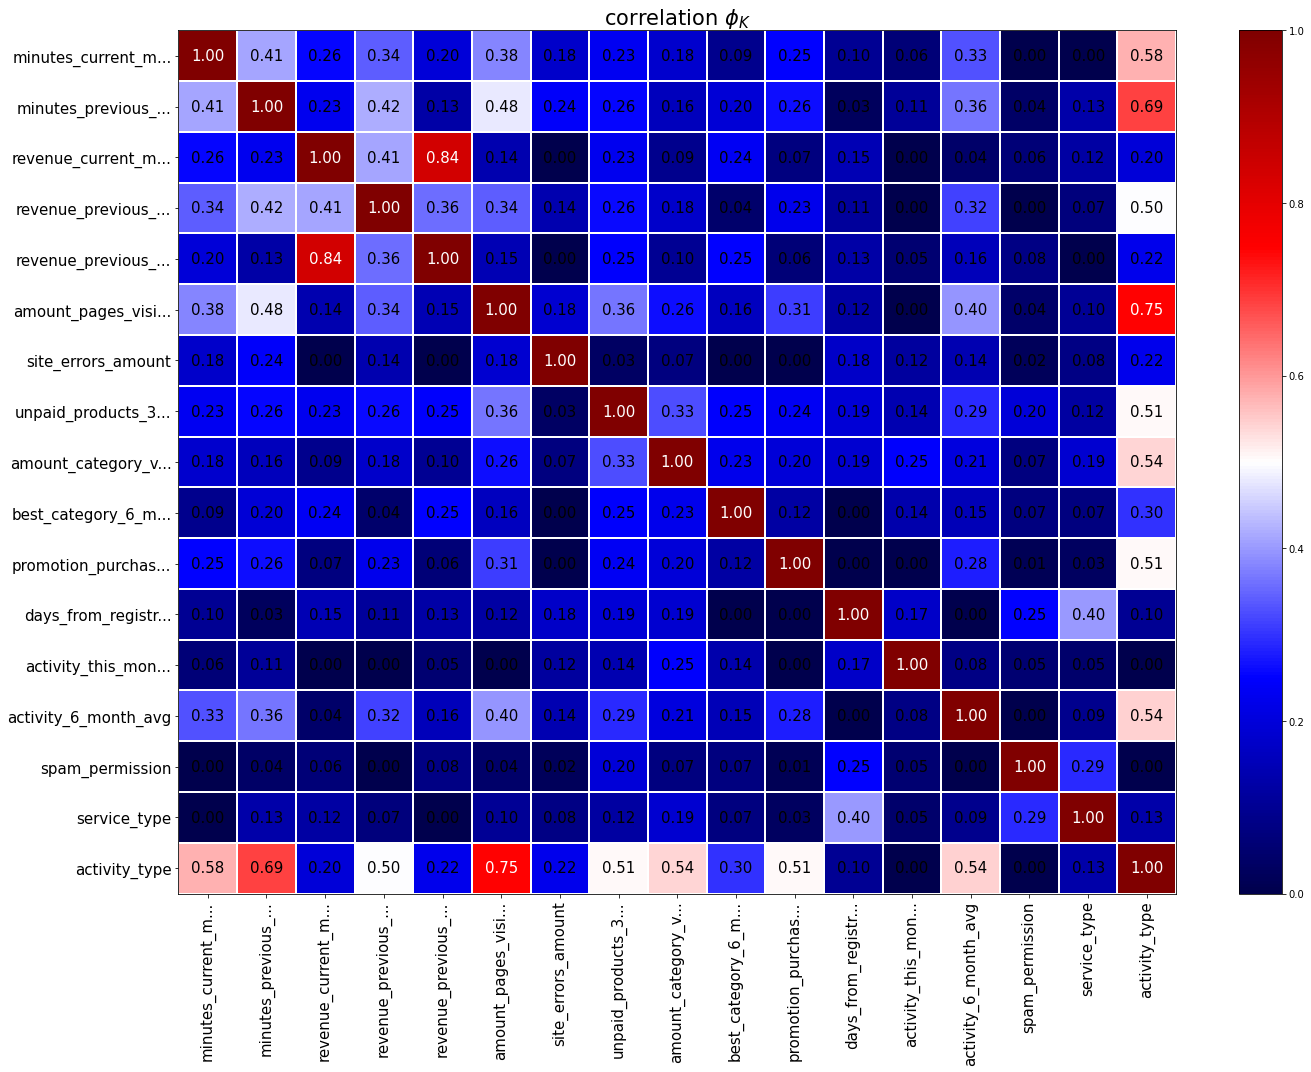

In [31]:
interval_cols = list(df_merged.select_dtypes(exclude='object').columns)
phik_overview = phik_matrix(df_merged, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='seismic',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

### Промежуточный вывод по корреляционному анализу
Наличие мультиколлинеарности между признаками не наблюдается, при это видно наличие хорошей коллинеарности между таргетом и остальными признаками

## Использование пайплайнов

Разделим данные на train и test

In [32]:
RANDOM_STATE = 42
y = df_merged['activity_type'].replace({'Снизилась': 1, 'Прежний уровень' : 0})
X = df_merged.drop('activity_type', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

Создадим пайплайн для масштабирования и кодирования данных

In [33]:
num_columns = list(df_merged.select_dtypes(exclude='object'))
ohe_columns = ['spam_permission', 'best_category_6_month']
ord_columns = ['service_type']
preprocessing = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), ohe_columns),
    ('num', MinMaxScaler(), num_columns),
    ('ord', OrdinalEncoder(categories=[['стандарт', 'премиум']]), ord_columns)
], remainder='passthrough')

final_p = Pipeline(steps=[
    ('preprocessor', preprocessing),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Создадим сетку по которой будет происходить подбор

In [34]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__min_samples_split': range(2, 5),
        'models__min_samples_leaf': range(1, 3),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ord': [OrdinalEncoder(categories=[['стандарт', 'премиум']]),
                              OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)],
        'preprocessor__ohe': [BinaryEncoder(),
                              OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)]
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ord': [OrdinalEncoder(categories=[['стандарт', 'премиум']]),
                              OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)],
        'preprocessor__ohe': [BinaryEncoder(),
                              OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)]
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ord': [OrdinalEncoder(categories=[['стандарт', 'премиум']]),
                              OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)],
        'preprocessor__ohe': [BinaryEncoder(),
                              OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)]
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 0.5,0.8, 1, 2],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ord': [OrdinalEncoder(categories=[['стандарт', 'премиум']]),
                              OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)],
        'preprocessor__ohe': [BinaryEncoder(),
                              OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)]
    }
]

Теперь проведём моделирования и с помощью RandomizedSearch подберём наилучшею модель, а также способы кодирования и масштабирования признаков. В качестве метрики будем использовать roc_auc score, ведь в данном случаем у нас нет сильного превалирования важности для нас precision и recall при это так как мы будем рассматривать вероятности, то хотелось бы оценить модель для разных порогов классификации.

In [35]:
randomized_search = RandomizedSearchCV(
    final_p,
    param_grid,
    n_iter=30,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
best_model = randomized_search.best_estimator_
print('Лучшая модель и её параметры:\n\n', best_model)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['spam_permission',
                                                   'best_category_6_month']),
                                                 ('num', StandardScaler(),
                                                  ['activity_6_month_avg',
                                                   'activity_this_month_avg',
                                                   'days_from_registration',
                                                   'promotion_purchases_6_month_avg',
                          

Посмотри на ближайшие по качеству модели.

In [36]:
results_df = pd.DataFrame(randomized_search.cv_results_)

# Отсортируем результаты по убыванию метрики
sorted_results = results_df.sort_values(by='mean_test_score', ascending=False)

# Выводим первые несколько строк (лучшие модели)
print('Топ-5 лучших моделей:')
sorted_results[['params', 'mean_test_score']].head(5)

Топ-5 лучших моделей:


,params,mean_test_score
18,{'preprocessor__ord': OneHotEncoder(drop='firs...,0.898284
0,{'preprocessor__ord': OrdinalEncoder(categorie...,0.896326
1,{'preprocessor__ord': OrdinalEncoder(categorie...,0.847444
22,{'preprocessor__ord': OneHotEncoder(drop='firs...,0.830888
20,{'preprocessor__ord': OneHotEncoder(drop='firs...,0.830616


In [37]:
best_model.fit(X_train, y_train)
activity_unchanged_prob = best_model.predict_proba(X_test)[:, 1]

In [38]:
print("Roc_auc score =", roc_auc_score(y_test, activity_unchanged_prob))

Roc_auc score = 0.9026374859708194


## Анализ важности признаков

Воссоздадим лучшую модель

In [39]:
best_preprocessing = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), ohe_columns),
    ('num', StandardScaler(), num_columns),
    ('ord', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), ord_columns)
], remainder='passthrough')
best_model = LogisticRegression(C=3, penalty='l1', random_state=42, solver='liblinear')
X_train_transformed = best_preprocessing.fit_transform(X_train)
X_test_transformed = best_preprocessing.transform(X_test)

feature_names = best_preprocessing.get_feature_names_out(input_features=X_train.columns)

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

best_model.fit(X_train_transformed_df, y_train);

In [40]:
print("Оценка на кросс валидации =", cross_val_score(best_model, X_train_transformed, y_train, cv=5, scoring='roc_auc').mean())

Оценка на кросс валидации = 0.8982844533653997


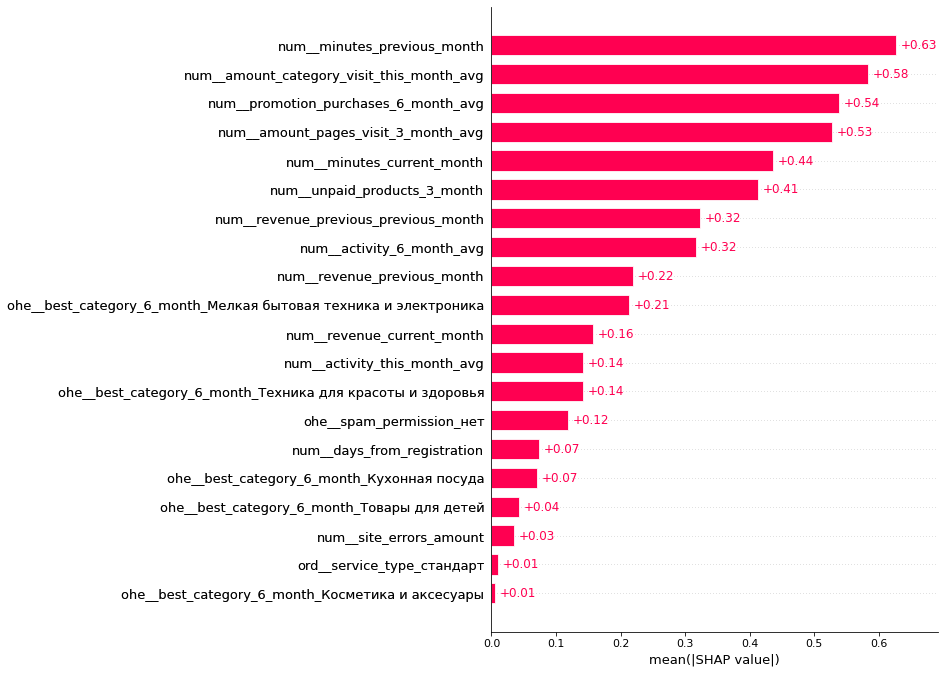

In [41]:
explainer = shap.LinearExplainer(best_model, X_test_transformed_df)
shap_values = explainer(X_test_transformed_df)
shap.plots.bar(shap_values, max_display=21)

Как показывает график наиболее важные признаки те, которые описывают активность клиента на сайте - количество просмотренных категорий и проведённое на сайте время. При этом достаточно важным также оказалось участие покупателя в акциях и выручка с него. Также стоить особую важность категорий товаров связанных с бытовой техникой и красотой и здоровьем.

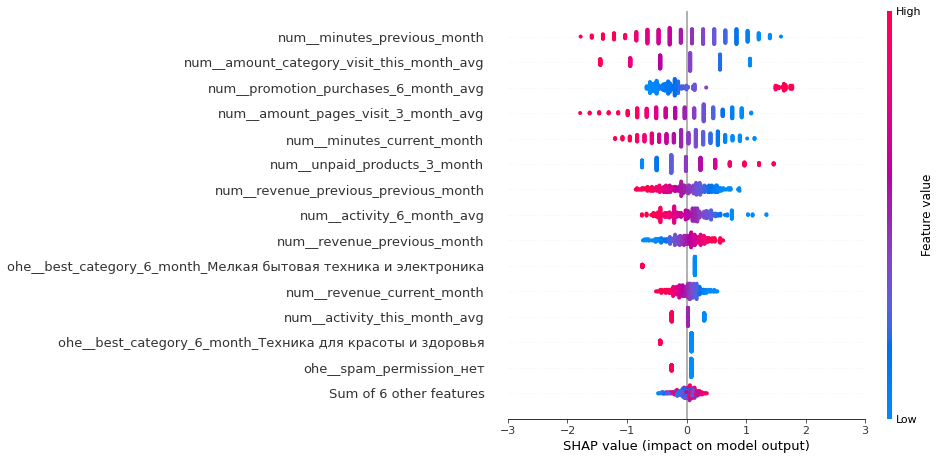

In [42]:
plt.xlim(-3, 3)
shap.plots.beeswarm(shap_values, max_display=15)

В большинстве своём увеличение признака ведёт к увеличению вероятности продолжения активности на сайте, при этом увеличение количества неоплаченных покупок и большой процент акционных товаров ведёт к снижению активности.

Заново проведём моделирование, при этом удалив неважные признаки

In [43]:
df_merged_best = df_merged.drop(['site_errors_amount', 'activity_this_month_avg', 'days_from_registration', 'spam_permission', 'service_type', 'activity_type'], axis=1)
num_columns = list(df_merged_best.select_dtypes(exclude='object'))
ohe_columns = list(df_merged_best.select_dtypes(include='object'))

In [44]:
X_train, X_test, y_train, y_test = train_test_split(df_merged_best, y, test_size=0.25, random_state=RANDOM_STATE)
best_preprocessing = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), ohe_columns),
    ('num', StandardScaler(), num_columns),
], remainder='passthrough')

X_train_transformed = best_preprocessing.fit_transform(X_train)
X_test_transformed = best_preprocessing.transform(X_test)

best_model = LogisticRegression(C=3, penalty='l1', random_state=42, solver='liblinear')

In [45]:
print("Оценка на кросс валидации =", cross_val_score(best_model, X_train_transformed, y_train, cv=5, scoring='roc_auc').mean())

Оценка на кросс валидации = 0.8993077403226841


### Промежуточный вывод по анализу признаков
Как было выяснено - наиболее важные признаки те, которые описывают активность клиента на сайте - количество просмотренных категорий и проведённое на сайте время. При этом достаточно важным также оказалось участие покупателя в акциях и выручка с него. Также стоить особую важность категорий товаров связанных с бытовой техникой и красотой и здоровьем.В большинстве своём увеличение признака ведёт к увеличению вероятности продолжения активности на сайте, при этом увеличение количества акционных покупок и неоплаченных покупок ведёт к снижению активности.Удалив ненужные признаки мы смогли незначительно повысить точность модели.

## Сегментация покупателей

Для начала проверим модель на тестовых данных

In [46]:
best_model.fit(X_train_transformed, y_train)
activity_unchanged_prob = best_model.predict_proba(X_test_transformed)[:, 1]

In [47]:
print("Roc_auc score =", roc_auc_score(y_test, activity_unchanged_prob))

Roc_auc score = 0.9075677409010743


Неплохой результат, мы можем сказать, что наша модель не переобучилась, теперь получим вероятности снижения активности, предсказанные моделью 

In [49]:
X_test['activity_lowering_prob'] = best_model.predict_proba(X_test_transformed)[:, 1]

Теперь добавим столбец с выручкой для дальнейшего анализа

In [50]:
df_with_proba_and_revenue = pd.merge(X_test, df_money, how='inner', left_index=True, right_index=True)

<Figure size 1440x1080 with 0 Axes>

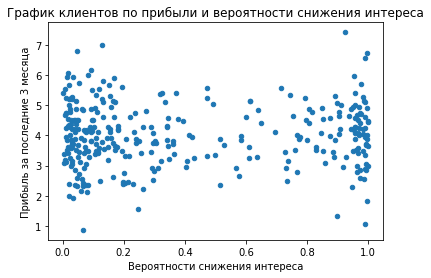

In [51]:
plt.figure(figsize=(20, 15))
df_with_proba_and_revenue.plot.scatter(x='activity_lowering_prob', y='revenue_3_month_avg')
plt.title("График клиентов по прибыли и вероятности снижения интереса")
plt.xlabel("Вероятности снижения интереса")
plt.ylabel("Прибыль за последние 3 месяца")
plt.show();

Видим, что есть такие клиенты, которые приносят хорошую прибыль и при этом имеют большую вероятность потери интереса - их точки расположены в правом верхнем углу. Попробуем их рассмотреть

In [52]:
df_target_clients = df_with_proba_and_revenue.query('activity_lowering_prob > 0.7 and revenue_3_month_avg > 4')

Посмотрим на распределения признаков для нашего сегмента по разным периодам

In [53]:
def columns_analysis(df):
    for column in df.select_dtypes(include='object').columns:
        df[column].value_counts().plot.pie(autopct='%1.1f%%')
        plt.title(column)
        plt.ylabel('')
        plt.figure(figsize=(10, 10))
        plt.show(block=False)
    for column in df.select_dtypes(exclude='object').columns:
        gs = GridSpec(1, 2, width_ratios=[5, 2], wspace=0.2, figure=plt.figure(figsize=(6, 5)))
        ax1 = plt.subplot(gs[0])
        if df[column].nunique() < 8:
            df[column].value_counts().sort_index().plot.bar()
        else:
            df[column].plot.kde()
        ax1.set_title(f"Распределение столбца {column}")  
        ax2 = plt.subplot(gs[1])
        text = df[column].describe().to_string()
        ax2.text(0, 0.5, text, ha='left', va='center', fontsize=12, linespacing=1.5)
        ax2.axis('off')
        plt.show()

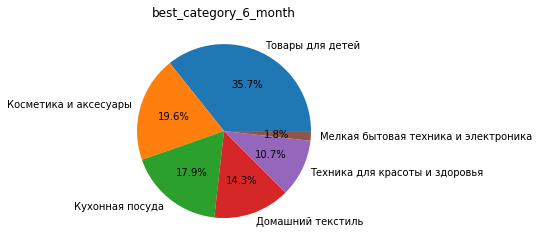

<Figure size 720x720 with 0 Axes>

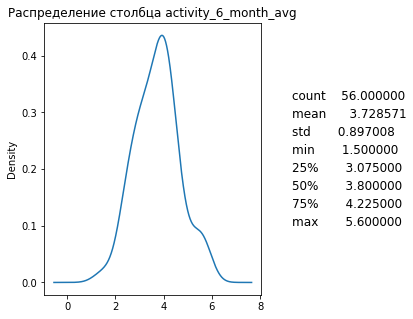

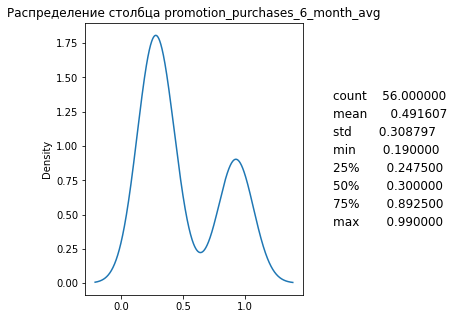

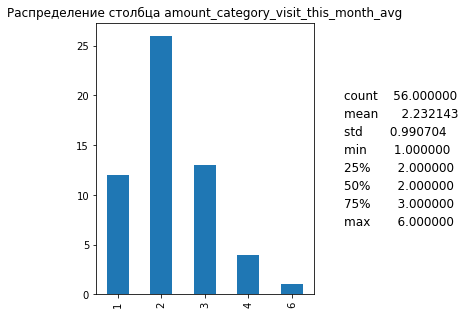

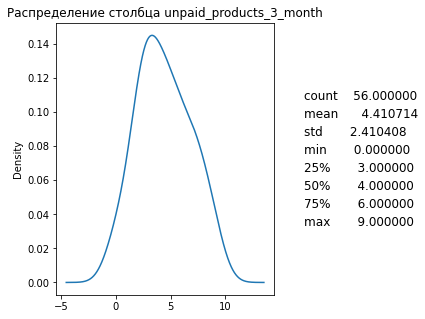

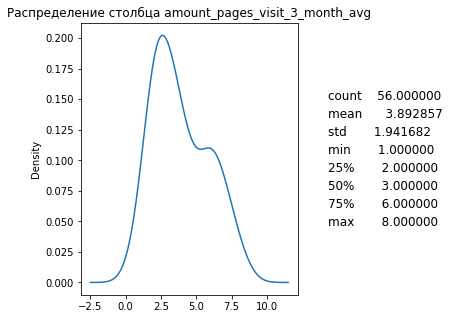

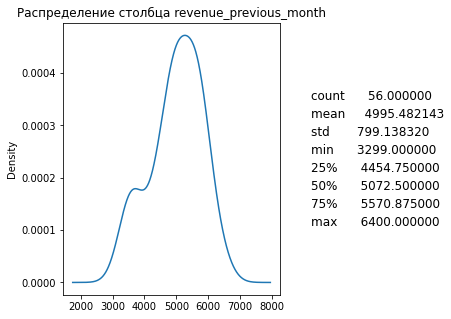

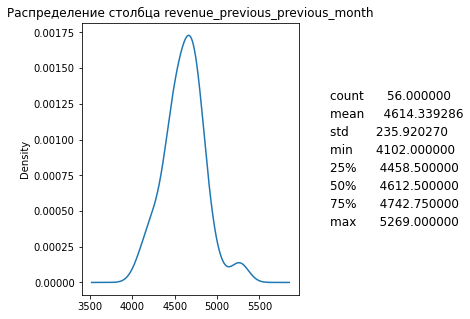

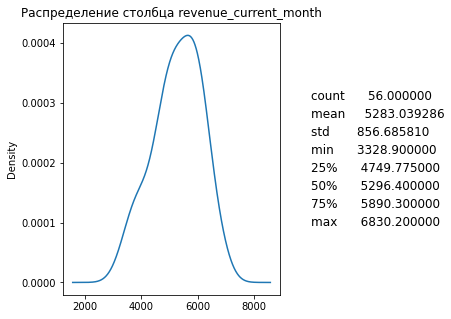

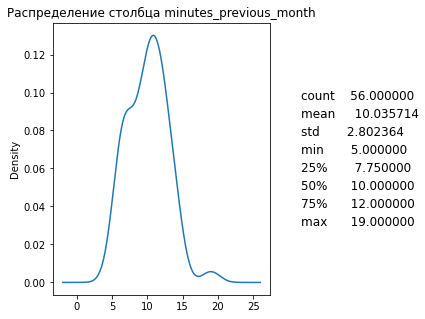

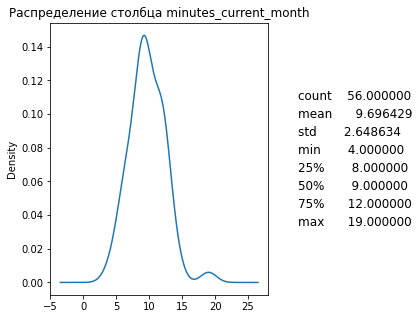

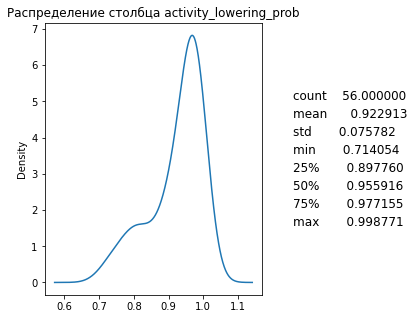

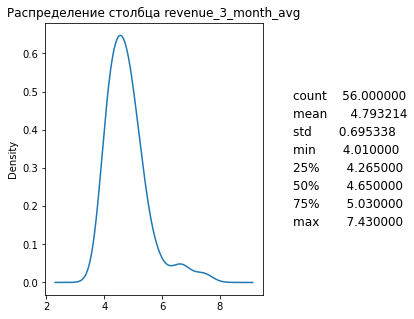

In [54]:
columns_analysis(df_target_clients)

В глаза бросаются сразу несколько отличий сегмента от остальных клиентов. Основной категорий для покупок в данной выборке являются товары для детей видно, что в принципе общее количество просмотренных категорий у таких клиентов в основном достаточно мало, а также доля людей здесь которые приходят в основном за покупками по акции достаточно велика. 

Теперь же рассмотри выручку по различным категориям за разные периоды, для этого нужно добавить стобец с разностью выручи за текущий и позапрошлые месяца.

In [55]:
df_target_clients['revenue_change'] = df_target_clients['revenue_current_month'] - df_target_clients['revenue_previous_previous_month']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


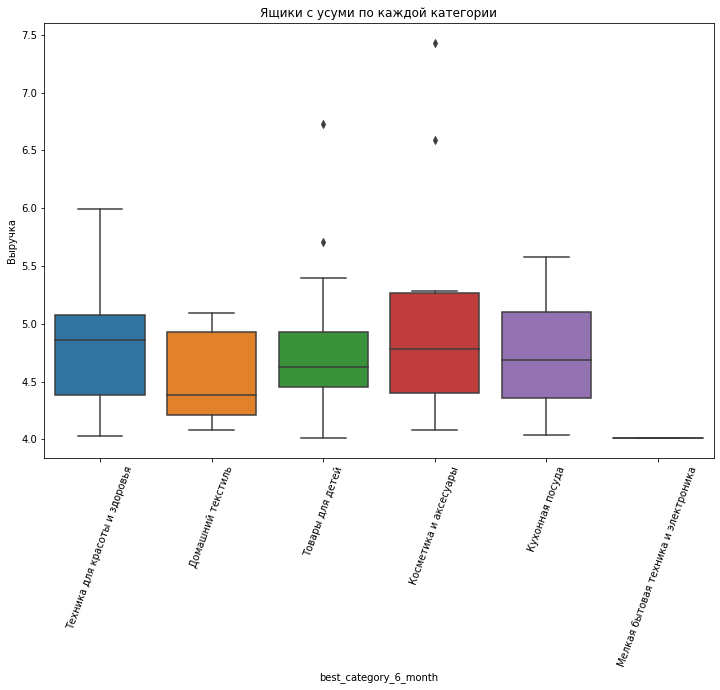

In [56]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='best_category_6_month', y='revenue_3_month_avg', data=df_target_clients)
plt.title('Ящики с усуми по каждой категории')
plt.ylabel('Выручка')
plt.xticks(rotation=70)
plt.show()

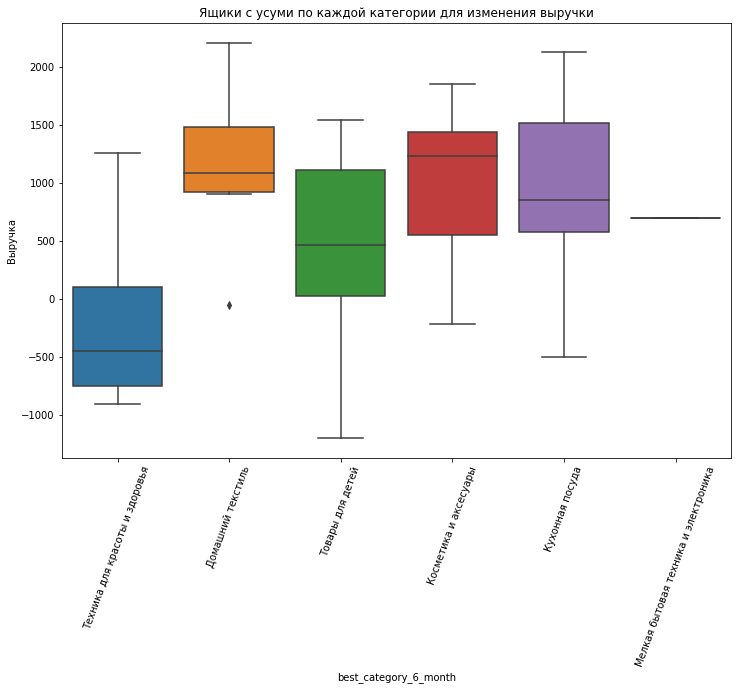

In [57]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='best_category_6_month', y='revenue_change', data=df_target_clients)
plt.title('Ящики с усуми по каждой категории для изменения выручки')
plt.ylabel('Выручка')
plt.xticks(rotation=70)
plt.show()

Видим, что в среднем по всем покупателям медианная выручка по всем категориям примерно равна, но если же обратить внимание на рассматриваемый сегмент, 
то мы видим, что категория крастота и здоровье стала сильно западать. Рекомендуется повысиь её популярность.

In [58]:
x1 = len(df_market_file[df_market_file['promotion_purchases_6_month_avg'] > 0.9]) / len(df_market_file) * 100
print("Процент людей, которые покупают больше 90% товаров на акциях в выбранном сегменте = ", round(x1), "%", sep="")
x2 = len(df_target_clients[df_target_clients['promotion_purchases_6_month_avg'] > 0.9]) / len(df_target_clients) * 100
print("Процент людей, которые покупают больше 90% товаров на акциях в общей выборке = ", round(x2), "%", sep="")

Процент людей, которые покупают больше 90% товаров на акциях в выбранном сегменте = 11%
Процент людей, которые покупают больше 90% товаров на акциях в общей выборке = 20%


Как видим закупка только по акциям является одним из отличительных признаков выбранного сегмента

## Вывод
В ходе данной работы была проведена предобработка данных, исследовательский и корреляционный анализ, также была найдена и протестирована модель для предсказания вероятности снижения пользовательской активности и на ееё основе проведён анализ исследуемого сегмента клиентов.
* В ходе предобработки не было найдено ни пропусков, ни явных дубликатов, мы лишь обработали данные для более удобной последующей обработки, а также были удалены выбросы для последующего более удобного моделирования.
*  При анализе данных было выяснено, что большинство числовых признаков показывают распределение похожее на нормальное, выделяется лишь столбец с долей купленных акционных товаров - мы видим два типа покупателей, тех кто иногда пользуется акциями и тех кто закупается только на них. По категориальным признакам можно сказать, что нет категории товаров с сильно большей долей - все примерно равны, согласие на спам дают большинство клиентов, так же как и большинство клиентов не пользуется премиум подпиской.
* Если же рассматривать данные с оглядкой на исследуемый признак, то можно заметить, что общее количество посещений сайта у людей соснизившейся активностью меньше, также видна их большая любовь к акциям, количество посещённых ими категорий в среднем меньше, они чаще не поатят за товары и в принципе за последние 3 месяца количество посещённых ими страниц меньше, чем у людей со стабильым интересом к сайту.
*  По исследуемому признаку мы видим, что покупательская активность снизилась у 40% клиентов. Заметной мультиколлинеарности обнаружено не было, при этом таргет показывал хорошую зависимость от остальные признаков
*  Для моделирования и последующего выбора наилучшей модели было использовано составление пайплайнов и RandomizedSearchCV. В качестве метрики был использован roc_auc score, ведь в данном случаем у нас нет сильного превалирования важности precision и recall при этом будут предсказываться вероятности, и поэтому хотелось бы оценить модель для разных порогов классификации.
*  Наилучшей моделью стала: LogisticRegression(C=3, penalty='l1', solver='liblinear')
* При исследовании важности признаков были выделены те, которые описывают активность клиента на сайте - количество просмотренных категорий и проведённое на сайте время - они оказывают наибольшее влияние на последующее поведение клиента. При этом достаточно важным также оказалось участие покупателя в акциях и выручка с него. Также стоить особую важность категорий товаров связанных с бытовой техникой и красотой и здоровьем. В большинстве своём увеличение признака ведёт к увеличению вероятности продолжения активности на сайте, при этом увеличение количества акционных покупок и неоплаченных покупок ведёт к снижению активности.
* Мы смогли ещё улучшить модель удалив ненужные признаки и в результате при кросс валидации метрика на тренировачной выборке была 0.899, при этом на тестовой выборке результат оказался не сильно хуже - 0.907. Модель оказалась неплохой, она показала достаточно малые разброс и смещение, поэтому на её основе был проведён анализ одного клиентского сегмента - а именно покупателей с большой вероятностью снижения активности, но при этом с большой приносимой прибылью
* В ходе исследования в глаза бросаются сразу несколько отличий сегмента от остальных клиентов. Основной категорий для покупок в данной выборке являются товары для детей видно, что в принципе общее количество просмотренных категорий у таких клиентов в основном достаточно мало, а также доля людей здесь которые приходят в основном за покупками по акции достаточно велика.
* При исследовании выручки по разным периодам мы увидели, что в среднем по клиентам медианная выручка по всем категориям примерно равна, но категория крастота и здоровье стала сильно западать за последние несколько месяцев. Рекомендуется повысиь её популярность.

В целом чтобы повысить популярность категории красота и здоровте логичным шагом будет проведений акций и скидок на данную групп товаров, возможно добавление специальных бонусов которые будут начисляться и тратиться в данной категории, также возможно вынесение данных товаров на главную страницу, для быстрого доступа к ним. Также раз именно эти клиенты не любят рассматривать разные категории можно выводить рекомендации только по любимым категориям или даже ввести программу лояльности которая за частые покупки в одной категории будет выдавать в ней скидки. Для любителей скидок возможно добавление маленьких, но постоянных скидок или повышение цен соразмерно выставленной скидки, чтобы привлечь клиента, но при этом не потерять много прибыли, ещё одной идеей может быть рекомендации им по акции уценённых и бракованных товаров, за очень малую сумму.
